# Dubins Car Summary

1. Plot Value Function given the NN
2. Plot Reach-Avoid Set based on analytic solutions and approximate value function

In [1]:
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)

from gym_reachability import gym_reachability  # Custom Gym env.
import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from collections import namedtuple
import os

from KC_DQN.DDQN import DDQN
from KC_DQN.config import dqnConfig

In [2]:
#== CONFIGURATION ==
toEnd = True
env_name = "dubins_car-v0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CONFIG = dqnConfig()


figureFolder = 'figure/paper/car/RA'  
os.makedirs(figureFolder, exist_ok=True)

In [3]:
# == Environment ==
envHigh = gym.make(env_name, device=device, mode='RA', doneType='toEnd')
envHigh.set_radius(inner_radius=.5, outer_radius=1., R_turn=.6)
print("Outer radius: {:.1f}, Inner radius: {:.1f}, Turn radius: {:.1f}, Maximum speed: {:.1f}, Maximum angular speed: {:.2f}".format(
    envHigh.outer_radius, envHigh.inner_radius, envHigh.R_turn, envHigh.speed, envHigh.max_turning_rate))

envLow = gym.make(env_name, device=device, mode='RA', doneType='toEnd')
envLow.set_radius(inner_radius=.5, outer_radius=1., R_turn=.8)
print("Outer radius: {:.1f}, Inner radius: {:.1f}, Turn radius: {:.1f}, Maximum speed: {:.1f}, Maximum angular speed: {:.2f}".format(
    envLow.outer_radius, envLow.inner_radius, envLow.R_turn, envLow.speed, envLow.max_turning_rate))

s_dim = envHigh.observation_space.shape[0]
action_num = envHigh.action_space.n
action_list = np.arange(action_num)
print(s_dim, action_num)

Env: mode---RA; doneType---toEnd
[-0.83333333  0.          0.83333333]
Outer radius: 1.0, Inner radius: 0.5, Turn radius: 0.6, Maximum speed: 0.5, Maximum angular speed: 0.83
Env: mode---RA; doneType---toEnd
[-0.625  0.     0.625]
Outer radius: 1.0, Inner radius: 0.5, Turn radius: 0.8, Maximum speed: 0.5, Maximum angular speed: 0.62
3 3


In [4]:
#== AGENT ==
agentHigh=DDQN(s_dim, action_num, CONFIG, action_list, mode='RA', model='TanhTwo')
agentHigh.restore('models/car/RA/big/model-{:d}.pth'.format(4000000))

agentLow=DDQN(s_dim, action_num, CONFIG, action_list, mode='RA', model='TanhTwo')
agentLow.restore('models/car/RA/small/model-{:d}.pth'.format(4000000))

Using two-layer NN architecture with Tanh act.
Using two-layer NN architecture with Tanh act.
=> Restore models/car/RA/big/model-4000000.pth
Using two-layer NN architecture with Tanh act.
Using two-layer NN architecture with Tanh act.
=> Restore models/car/RA/small/model-4000000.pth


In [5]:
envList = [envHigh, envLow]
agentList = [agentHigh, agentLow]

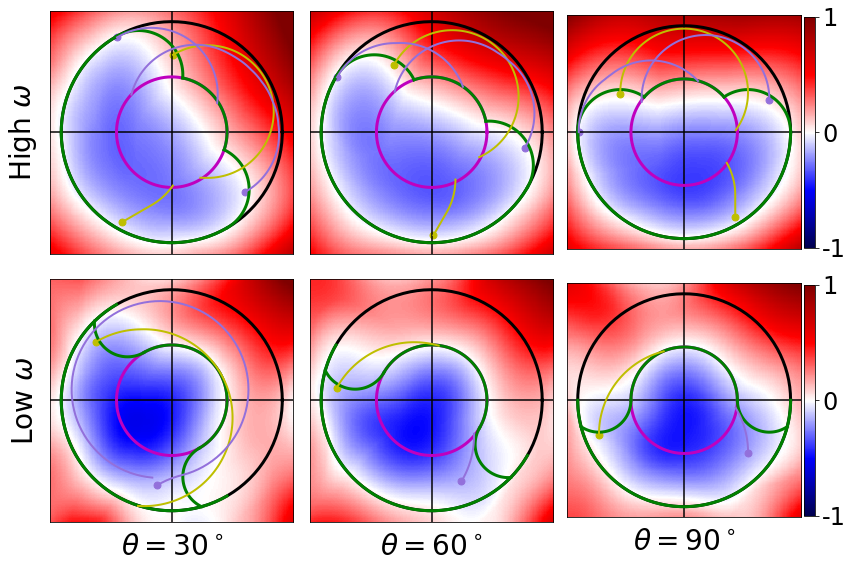

In [6]:
thetaList = np.array([np.pi/6, np.pi/3, np.pi/2])

# Plot Value Function from Different Heading angles ==
fig, axes = plt.subplots(2, 3, figsize=(12,8), sharex=True, sharey=True)

for j, (axRow, env, agent) in enumerate(zip(axes, envList, agentList)):
    r = env.inner_radius
    R = env.outer_radius
    R_turn = env.R_turn
    if j == 0:
        cList = ['y', '#9370DB', 'y', '#9370DB']
        states = [np.array([ -R_turn, .9*(R-R_turn), np.pi/2]),
                  np.array([ -.99*R, 0., np.pi/2]),
                  np.array([.8*R_turn, -.8, np.pi/2]),
                  np.array([ .8*R, .75*(R-R_turn), np.pi/2])]
    else:
        cList = ['y', '#9370DB']
        states = [np.array([ -R_turn, -1.1*(R_turn-r), np.pi/2]),
                  np.array([ .6*R,  -.5, np.pi/2])]
    for i, (ax, theta) in enumerate(zip(axRow, thetaList)):
        if i == thetaList.shape[0]-1:
            cbarPlot=True
        else: 
            cbarPlot=False
        #== Plot Value Function ==    
        env.plot_v_values(  agent.Q_network, theta=theta, ax=ax, fig=fig,
                            vmin=-1, vmax=1, nx=201, ny=201, cmap='seismic',
                            boolPlot=False, cbarPlot=cbarPlot)
        #== Plot failure / target set ==
        env.plot_target_failure_set(ax)

        #== Plot reach-avoid set ==
        env.plot_reach_avoid_set(ax, orientation=theta)

        #= Plot Trajectories ==
        for c, state in zip(cList, states):
            env.plot_trajectories(agent.Q_network, T=200, states=[state], toEnd=False, 
                                      ax=ax, c=c, lw=2, orientation = theta-np.pi/2)

        #== Formatting ==
        env.plot_formatting(ax=ax)
        
        if j == 1:
            ax.set_xlabel(r'$\theta={:.0f}^\circ$'.format(theta*180/np.pi), fontsize=28)
axes[0][0].set_ylabel(r'High $\omega$', fontsize=28)
axes[1][0].set_ylabel(r'Low $\omega$', fontsize=28)
plt.tight_layout()
fig.savefig('{:s}/valueDiffTheta.eps'.format(figureFolder))

## Reach-Avoid Set given the optimal policy

In [7]:
from dubinsCarAnalytics.utilsDCAnalytics import *
orientation = np.pi/2

In [8]:
nx, ny = 101, 101

#== Rollout Reach-Avoid Set ==
resultMtxList = []
for j, (env, agent) in enumerate(zip(envList, agentList)):
    resultMtx = np.empty((nx, ny), dtype=int)
    xs = np.linspace(env.bounds[0,0], env.bounds[0,1], nx)
    ys =np.linspace(env.bounds[1,0], env.bounds[1,1], ny)

    it = np.nditer(resultMtx, flags=['multi_index'])

    while not it.finished:
        idx = it.multi_index
        x = xs[idx[0]]
        y = ys[idx[1]]

        state = np.array([x, y, orientation])
        traj_x, traj_y, result = env.simulate_one_trajectory(agent.Q_network, T=400, state=state, toEnd=False)

        resultMtx[idx] = result
        it.iternext()
    resultMtxList.append(resultMtx)

/Users/kaichieh/Desktop/RL_REACHAVOID/dubinsCarAnalytics/utilsDCAnalytics.py:106: RuntimeWarning: invalid value encountered in sqrt
  bool0 = ( xtilde <= np.sqrt( (R - R_turn)**2 - (R_turn - np.abs(ytilde))**2 ) )


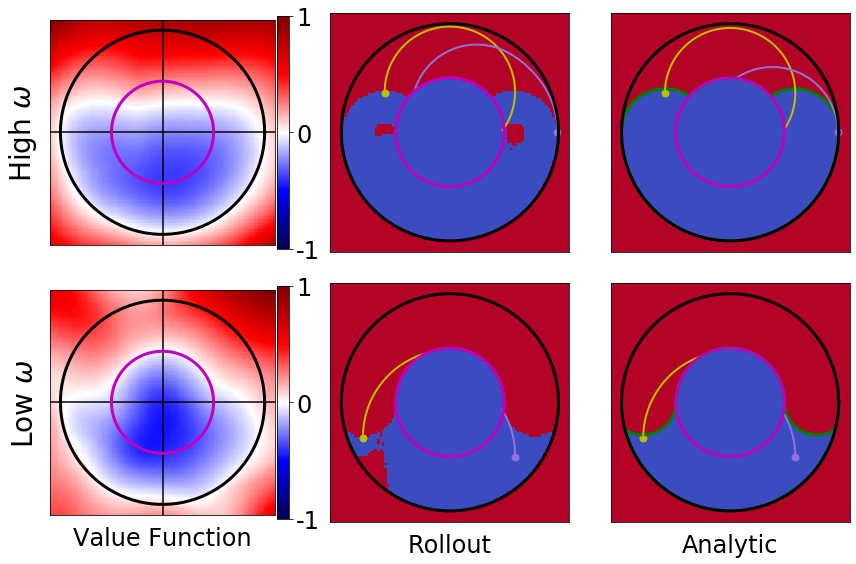

In [9]:
#== Plot Reach-Avoid Set based on analytic solutions and approximate value function ==
fig, axes = plt.subplots(2, 3, figsize=(12,8), sharex=True, sharey=True)
#fig, axes = plt.subplots(2, 2, figsize=(8,8), sharex=True, sharey=True)

for j, (axRow, env, agent, resultMtx) in enumerate(zip(axes, envList, agentList, resultMtxList)):
    r = env.inner_radius
    R = env.outer_radius
    R_turn = env.R_turn
    if j == 0:
        state1 = [np.array([ -R_turn, .9*(R-R_turn), np.pi/2])]
        state2 = [np.array([ .99*R, 0., np.pi/2])]
    else:
        state1 = [np.array([ -R_turn, -1.1*(R_turn-r), np.pi/2])]
        state2 = [np.array([ .6*R,  -.5, np.pi/2])]
    
    axStyle = env.get_axes()

    #== Value Function ==
    
    ax = axRow[0]
    env.plot_v_values(  agent.Q_network, theta=orientation, ax=ax, fig=fig,
                        vmin=-1, vmax=1, nx=nx, ny=ny, cmap='seismic',
                        boolPlot=False, cbarPlot=True)
    if j == 1:
        ax.set_xlabel('Value Function', fontsize=24)
    

    #== Analytic ==
    ax = axRow[2]
    if j == 0:
        areaRA = plot_reach_avoid_type_1(R, R_turn, r, orientation, ax=ax, extent=axStyle[0])
    else:
        plot_reach_avoid_type_2(R, R_turn, r, orientation, ax=ax, extent=axStyle[0])

    x = state1[0][0] + R_turn
    y = state1[0][1]
    thetas = np.linspace(np.pi, -np.pi/2, 100)
    xs = x + R_turn * np.cos(thetas)
    ys = y + R_turn * np.sin(thetas)
    tmp = xs**2 + ys**2
    idx = np.where(tmp<r**2)[0][0]
    ax.plot(xs[:idx], ys[:idx], c='y', lw=2)
    ax.scatter(xs[0], ys[0], s=48, c='y')

    x = state2[0][0] - R_turn
    y = state2[0][1]
    thetas = np.linspace(0, np.pi, 100)
    xs = x + R_turn * np.cos(thetas)
    ys = y + R_turn * np.sin(thetas)
    tmp = xs**2 + ys**2
    idx = np.where(tmp<r**2)[0][0]
    ax.plot(xs[:idx], ys[:idx], c='#9370DB', lw=2)
    ax.scatter(xs[0], ys[0], s=48, c='#9370DB')

    if j == 1:
        ax.set_xlabel('Analytic', fontsize=24)
        
    #== Approximate ==
    ax = axRow[1]
    im = ax.imshow(resultMtx.T != 1, interpolation='none', extent=axStyle[0], origin="lower",
                   cmap='coolwarm', vmin=0, vmax=1)
    env.plot_trajectories(agent.Q_network, T=200, states=state1, toEnd=False, 
                          ax=ax, c='y', lw=2, orientation = orientation-np.pi/2)
    env.plot_trajectories(agent.Q_network, T=200, states=state2, toEnd=False, 
                          ax=ax, c='#9370DB', lw=2, orientation = orientation-np.pi/2)
    if j == 1:
        ax.set_xlabel('Rollout', fontsize=24)

    #== Formatting ==
    for ax in axRow:
        env.plot_target_failure_set(ax=ax)
        env.plot_formatting(ax=ax)

axes[0][0].set_ylabel(r'High $\omega$', fontsize=28)
axes[1][0].set_ylabel(r'Low $\omega$', fontsize=28)
plt.tight_layout()
fig.savefig('{:s}/analyticRolloutCompare.eps'.format(figureFolder))